In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.Seq import Seq
import pysam
import random
from scipy.stats import spearmanr
from Bio.SeqUtils import MeltingTemp as mt

/home/ubuntu/mambaforge/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
def reverse_complement(seq):
    # Mapping of nucleotides to their complements
    complement_dict = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C','N':'N'}

    # Generate the complement for each nucleotide and reverse the sequence
    return ''.join(complement_dict[nuc] for nuc in reversed(seq))

cs_data_file = 'data/TB000208a.outputs.xlsx'
data_path = 'data/TB000208a'
train_sheets = ['GT-Rep1-N7_S1','GT-Rep2-N7_S2','GT-Rep3-N7_S3']
test_sheets = ['Pool-Rep1-N7_S4','Pool-Rep2-N7_S5','Pool-Rep3-N7_S6']

Pool_rep1 = pd.read_excel(cs_data_file, sheet_name=test_sheets[0])
Pool_rep2 = pd.read_excel(cs_data_file, sheet_name=test_sheets[1])
Pool_rep3 = pd.read_excel(cs_data_file, sheet_name=test_sheets[2])

Pool_rep1 = Pool_rep1.sort_values(by='count',ascending=False).reset_index(drop=True)
Pool_rep2 = Pool_rep2.sort_values(by='count',ascending=False).reset_index(drop=True)
Pool_rep3 = Pool_rep3.sort_values(by='count',ascending=False).reset_index(drop=True)

Pool_rep1_seq_deduped = Pool_rep1.drop_duplicates(subset='seq')
Pool_rep2_seq_deduped = Pool_rep2.drop_duplicates(subset='seq')
Pool_rep3_seq_deduped = Pool_rep3.drop_duplicates(subset='seq')

cryptic_seq_df = pd.merge(Pool_rep1_seq_deduped, Pool_rep2_seq_deduped, on=['chrom', 'seq_start','seq_end','genome_dinucleotide','strand'], how='outer')
cryptic_seq_df = pd.merge(cryptic_seq_df, Pool_rep3_seq_deduped, on=['chrom', 'seq_start','seq_end','genome_dinucleotide','strand'], how='outer')

# cryptic_seq_df = cryptic_seq_df.groupby(['chrom', 'seq_start','seq_end']).sum().reset_index()

# set NAs 
cryptic_seq_df['count'] = cryptic_seq_df['count'].fillna(0)
cryptic_seq_df['count_x'] = cryptic_seq_df['count_x'].fillna(0)
cryptic_seq_df['count_y'] = cryptic_seq_df['count_y'].fillna(0)

# Add the counts from each DataFrame
cryptic_seq_df['total_count'] = cryptic_seq_df[['count','count_x','count_y']].mean(axis=1)

# print(cryptic_seq_df.columns)

cryptic_seq_df = cryptic_seq_df[['chrom','seq_start','seq_end','genome_dinucleotide','strand','total_count']]

on_target_total_count = cryptic_seq_df[(cryptic_seq_df.chrom == 'PL312') & (cryptic_seq_df.seq_start == 2905)]['total_count'].reset_index(drop=True).loc[0]

cryptic_seq_df = cryptic_seq_df[cryptic_seq_df['chrom'].str.contains('chr')]

# Load the indexed reference genome
fasta_file = "/data/references/hg38.fa"
fasta = pysam.FastaFile(fasta_file)
sequences = []
for index,row in cryptic_seq_df.iterrows():
    chrom = row['chrom']
    if 'chr' not in chrom:
        continue
    start = row['seq_start']
    end = row['seq_end']
    
    sequence = fasta.fetch(chrom, start-1, end).upper()
    if row['strand'] == '-':
        sequence = reverse_complement(sequence)
    sequences.append(sequence)
cryptic_seq_df['sequence'] = sequences

cryptic_seq_df['sequence'] = cryptic_seq_df['sequence'].apply(lambda x: x[:22] + 'NN' + x[24:])

cryptic_seq_df['total_count_normalized'] = cryptic_seq_df['total_count'] / on_target_total_count


In [3]:
cryptic_seq_df

,chrom,seq_start,seq_end,genome_dinucleotide,strand,total_count,sequence,total_count_normalized
0,chr14_KI270724v1_random,1401,1446,TG,-,7210.666667,TGCGGGTTTGCGGGCAACCGCCNNGGCTGTGGGAGGAGCCCGGGCA,3.923105
1,chr14_GL000225v1_random,54345,54390,TG,+,3425.666667,CACGGGTTTGCGGGCAGCCGCANNGGCTGTGGGAGCAGCCCGGGCA,1.863801
2,chr14_GL000225v1_random,44324,44369,CA,-,2668.000000,TGCCCGGGCTGCTCCCACAGCCNNGGCAGCTGCCCGCAAACCCGCG,1.451578
3,chr17,31561265,31561310,TG,-,2510.333333,TCCCATAATTCTGACATCTGCANNTTCCACTGGGTAAGCCTCCAGG,1.365796
4,chr14_KI270723v1_random,36190,36235,CA,-,2388.333333,TACCCGGGCTCCTCCCACAGCCNNGGCGGTTGCCCGCAAACCCGCG,1.299420
...,...,...,...,...,...,...,...,...
166899,chr4,126301887,126301932,CT,-,0.333333,ATTTAGGATTTCATCTCCAGCTNNTTCCATTTATAGGAGCACAAAT,0.000181
166900,chr4,120689801,120689846,CA,+,0.333333,GATGGGGTTTCGCCATGTTGCANNGGCTGTTGTCGAACTCCTGGGC,0.000181
166901,chr4,120825821,120825866,TG,-,0.333333,GGGTATGGTTCAGACAATTGATNNGTATCTGAGGTCCAAACCAGAG,0.000181
166902,chr4,120892499,120892544,AG,-,0.333333,AACTGTGGTTCCTACCTGAGAGNNCCCTGTGGACCAGAACACTCAA,0.000181


Training with hidden size: 500
Epoch [1/20], Loss: 1.4952171178791653
Test Loss: 1.424903225396328
Epoch [2/20], Loss: 1.163568591093327
Test Loss: 1.1328695580877106
Epoch [3/20], Loss: 1.0728391931000367
Test Loss: 1.2329529997717832
Epoch [4/20], Loss: 1.018634772699269
Test Loss: 1.0774815168188907
Epoch [5/20], Loss: 0.9675414457130269
Test Loss: 1.057831676184446
Epoch [6/20], Loss: 0.9082969973146204
Test Loss: 1.0972463598196533
Epoch [7/20], Loss: 0.8270255437254068
Test Loss: 1.0018814703970578
Epoch [8/20], Loss: 0.7675879088625489
Test Loss: 1.102074960867564
Epoch [9/20], Loss: 0.7176734105742567
Test Loss: 1.002003564916808
Epoch [10/20], Loss: 0.6723803417785712
Test Loss: 1.0217602790772229
Epoch [11/20], Loss: 0.6356625703165032
Test Loss: 1.0569777765036543
Epoch [12/20], Loss: 0.6014247509877767
Test Loss: 1.052529462795148
Epoch [13/20], Loss: 0.5694095911347073
Test Loss: 1.0630212163559778
Epoch [14/20], Loss: 0.5457495052995734
Test Loss: 1.062415033122132
Epoch 

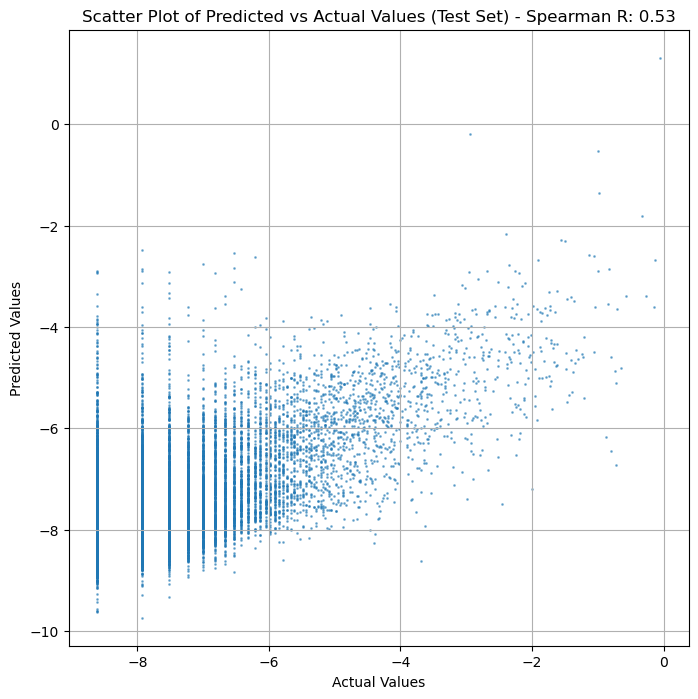

In [5]:
# Define a function to convert DNA sequences to one-hot encoding
def sequence_to_one_hot(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1],'N': [0, 0, 0, 0]}

    one_hot = [mapping[base] for base in sequence]

    return np.array(one_hot)

# Features and target
X = cryptic_seq_df['sequence']
y = np.log(cryptic_seq_df['total_count_normalized'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)

# Convert sequences to one-hot encoding using apply
X_train = np.array([sequence_to_one_hot(seq) for seq in X_train])
X_test = np.array([sequence_to_one_hot(seq) for seq in X_test])

X_train_flatten = X_train.reshape(*X_train.shape[:-2], -1)
X_test_flatten = X_test.reshape(*X_test.shape[:-2], -1)

y_train = np.array(y_train)
y_test = np.array(y_test)

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for training and testing
batch_size = 64
train_dataset = CustomDataset(X_train_flatten, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(X_test_flatten, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the MLP model architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.01)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define loss function and optimizer
criterion = nn.MSELoss()
# List of different hidden sizes to test
hidden_sizes = [500]

# Store the training and test losses for each hidden size
train_losses = []
test_losses = []


for hidden_size in hidden_sizes:
    # Initialize the model
    input_size = 46*4 
    output_size = 1 
    # Store predicted and actual values for all models
    all_predicted = []
    all_actual = []
    print(f"Training with hidden size: {hidden_size}")

    model = MLP(input_size, hidden_size, output_size)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 20
    train_loss_list = []

    best_test_loss = float('inf')
    best_model_params = None
    best_all_predicted = None
    best_all_actual = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss_list.append(total_loss / len(train_loader))
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}")

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            test_loss = 0
            all_predicted_epoch = []
            all_actual_epoch = []
            for inputs, targets in test_loader:
                outputs = model(inputs)
                test_loss += criterion(outputs, targets.view(-1, 1)).item()
                all_predicted_epoch.extend(outputs.view(-1).cpu().numpy())
                all_actual_epoch.extend(targets.view(-1).cpu().numpy())
            test_losses.append(test_loss / len(test_loader))
            print(f"Test Loss: {test_loss / len(test_loader)}")

            # Save the model if this is the best test loss so far
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_params = model.state_dict()
                best_all_predicted = all_predicted_epoch
                best_all_actual = all_actual_epoch

    # Save the best model
    torch.save(best_model_params, 'mlp_best_model.pt')


# Calculate R-squared value
r_squared = spearmanr(best_all_actual, best_all_predicted).statistic

# Plot the scatter plot of predicted vs actual values for the entire test set
plt.figure(figsize=(8, 8))
plt.scatter(best_all_actual, best_all_predicted, alpha=0.5, s=1)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Scatter Plot of Predicted vs Actual Values (Test Set) - Spearman R: {r_squared:.2f}')
plt.grid()
plt.show()


Training with hidden size: 64
Epoch [1/75], Loss: 2.9084046697291646
Test Loss: 1.7460331935078706
Epoch [2/75], Loss: 1.7221932521112124
Test Loss: 1.7473959587086205
Epoch [3/75], Loss: 1.7217018126273684
Test Loss: 1.7481580406313197
Epoch [4/75], Loss: 1.721108572329101
Test Loss: 1.7470597987887504
Epoch [5/75], Loss: 1.702459930561267
Test Loss: 1.6956506570180256
Epoch [6/75], Loss: 1.6673374057349193
Test Loss: 1.6796701041217965
Epoch [7/75], Loss: 1.649892371090754
Test Loss: 1.6625263572195936
Epoch [8/75], Loss: 1.6266316707282498
Test Loss: 1.6331527333606706
Epoch [9/75], Loss: 1.5804946797263684
Test Loss: 1.6542577195441586
Epoch [10/75], Loss: 1.5125777722293514
Test Loss: 1.5215124373691749
Epoch [11/75], Loss: 1.4397727866138266
Test Loss: 1.4026733303435461
Epoch [12/75], Loss: 1.3753125783582765
Test Loss: 1.3200461583575984
Epoch [13/75], Loss: 1.3148504911177812
Test Loss: 1.2995005094685317
Epoch [14/75], Loss: 1.2618989797857998
Test Loss: 1.2367846922399441
Ep

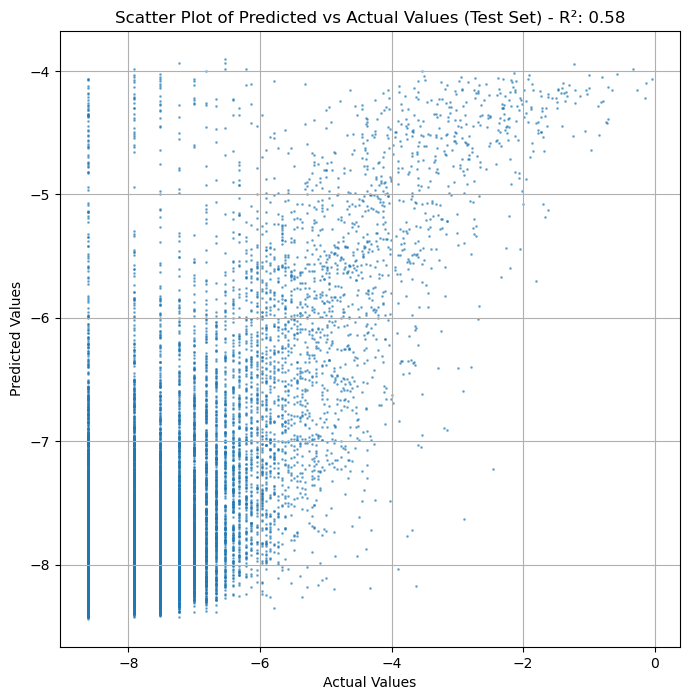

In [63]:

# Split the filtered dataset into training and testing sets
X = cryptic_seq_df['sequence']

y = np.log(cryptic_seq_df['total_count_normalized'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define a function to convert DNA sequences to one-hot encoding
def sequence_to_one_hot(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1],'N': [0, 0, 0, 0]}

    one_hot = [mapping[base] for base in sequence]

    return np.array(one_hot)

# Convert sequences to one-hot encoding using apply
X_train = np.array([sequence_to_one_hot(seq) for seq in X_train])
X_test = np.array([sequence_to_one_hot(seq) for seq in X_test])

y_train = np.array(y_train)
y_test = np.array(y_test)

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for training and testing
batch_size = 64
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        out = self.relu(out)

        # Decode the hidden state of the last time step
        out = self.fc1(out[:, -1, :])

        return out

# Define loss function and optimizer
criterion = nn.MSELoss()
# List of different hidden sizes to test
hidden_sizes = [64]

# Store the training and test losses for each hidden size
train_losses = []
test_losses = []


for hidden_size in hidden_sizes:
    # Store predicted and actual values for all models
    all_predicted = []
    all_actual = []
    print(f"Training with hidden size: {hidden_size}")

    # Initialize the model
    input_size = 4 # 4 features per position (one-hot encoded)
    output_size = 1  # Regression, so one output
    num_layers = 2  # Number of LSTM layers
    model = LSTMModel(input_size, hidden_size, output_size, num_layers)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 75
    train_loss_list = []

    best_test_loss = float('inf')
    best_model_params = None
    best_all_predicted = None
    best_all_actual = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss_list.append(total_loss / len(train_loader))
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}")

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            test_loss = 0
            all_predicted_epoch = []
            all_actual_epoch = []
            for inputs, targets in test_loader:
                outputs = model(inputs)
                test_loss += criterion(outputs, targets.view(-1, 1)).item()
                all_predicted_epoch.extend(outputs.view(-1).cpu().numpy())
                all_actual_epoch.extend(targets.view(-1).cpu().numpy())
            test_losses.append(test_loss / len(test_loader))
            print(f"Test Loss: {test_loss / len(test_loader)}")
            # Plot the scatter plot of predicted vs actual values for the entire test set
            # plt.figure(figsize=(8, 8))
            # plt.scatter(all_predicted_epoch, all_actual_epoch, alpha=0.5, s=1)
            # plt.xlabel('Predicted Values')
            # plt.ylabel('Actual Values')
            # plt.title(f'Scatter Plot of Predicted vs Actual Values (Test Set))')
            # plt.grid()
            # plt.show()
            

            # Save the model if this is the best test loss so far
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_params = model.state_dict()
                best_all_predicted = all_predicted_epoch
                best_all_actual = all_actual_epoch

    # Save the best model
    torch.save(best_model_params, 'lstm_best_model.pt')


# Calculate R-squared value
r_squared = spearmanr(best_all_actual, best_all_predicted).statistic

# Plot the scatter plot of predicted vs actual values for the entire test set
plt.figure(figsize=(8, 8))
plt.scatter(best_all_actual, best_all_predicted, alpha=0.5, s=1)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Scatter Plot of Predicted vs Actual Values (Test Set) - R²: {r_squared:.2f}')
plt.grid()
plt.show()

In [112]:
import torch.nn.functional as F

# Split the filtered dataset into training and testing sets
X = cryptic_seq_df['sequence']

y = np.log(cryptic_seq_df['total_count_normalized'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define a function to convert DNA sequences to one-hot encoding
def sequence_to_one_hot(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1],'N': [0, 0, 0, 0]}
    complement_dict = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C','N':'N'}

    one_hot = [mapping[base] for base in sequence]

    rv_comp_sequence = ''.join(complement_dict[nuc] for nuc in reversed(sequence))

    one_hot_rv = [mapping[base] for base in rv_comp_sequence]

    c = np.concatenate((one_hot, one_hot_rv), 1)
    return np.array(c)

# Convert sequences to one-hot encoding using apply
X_train = np.array([sequence_to_one_hot(seq) for seq in X_train])
X_test = np.array([sequence_to_one_hot(seq) for seq in X_test])

y_train = np.array(y_train)
y_test = np.array(y_test)

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for training and testing
batch_size = 64
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CNNModel, self).__init__()
        
        # Define convolutional layers with different filter sizes
        self.conv3 = nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=5, padding=2)
        self.conv7 = nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=7, padding=3)

        # Define a fully connected layer for the final output
        self.fc = nn.Linear(128 * 3, output_size)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.transpose(1, 2)
        # Apply convolutional layers with different filter sizes
        conv3_out = self.relu(self.conv3(x))
        conv5_out = self.relu(self.conv5(x))
        conv7_out = self.relu(self.conv7(x))

        # Concatenate the outputs from the different convolutional layers
        concatenated = torch.cat([conv3_out, conv5_out, conv7_out], dim=1)

        # Global average pooling
        pooled = F.avg_pool1d(concatenated, concatenated.shape[2]).squeeze(2)

        # Pass the pooled output to the fully connected layer
        out = self.fc(pooled)
        return out

# Define loss function and optimizer
criterion = nn.MSELoss()
# List of different hidden sizes to test
hidden_sizes = [64]

for hidden_size in hidden_sizes:
    # Store predicted and actual values for all models
    all_predicted = []
    all_actual = []
    print(f"Training with hidden size: {hidden_size}")

    # Initialize the model
    input_size = 8  # 4 features per position (one-hot encoded)
    output_size = 1  # Regression, so one output
    num_layers = 1  # Number of LSTM layers
    model = CNNModel(input_size, output_size)

    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    num_epochs = 75
    train_loss_list = []

    best_test_loss = float('inf')
    best_model_params = None
    best_all_predicted = None
    best_all_actual = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss_list.append(total_loss / len(train_loader))
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}")

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            test_loss = 0
            all_predicted_epoch = []
            all_actual_epoch = []
            for inputs, targets in test_loader:
                outputs = model(inputs)
                test_loss += criterion(outputs, targets.view(-1, 1)).item()
                all_predicted_epoch.extend(outputs.view(-1).cpu().numpy())
                all_actual_epoch.extend(targets.view(-1).cpu().numpy())
            test_losses.append(test_loss / len(test_loader))
            print(f"Test Loss: {test_loss / len(test_loader)}")
            

            # Save the model if this is the best test loss so far
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_params = model.state_dict()
                best_all_predicted = all_predicted_epoch
                best_all_actual = all_actual_epoch

    # Save the best model
    torch.save(best_model_params, 'lstm_best_model.pt')


# Calculate R-squared value
r_squared = spearmanr(best_all_actual, best_all_predicted).statistic

# Plot the scatter plot of predicted vs actual values for the entire test set
plt.figure(figsize=(8, 8))
plt.scatter(best_all_actual, best_all_predicted, alpha=0.5, s=1)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Scatter Plot of Predicted vs Actual Values (Test Set) - R²: {r_squared:.2f}')
plt.grid()
plt.show()

Training with hidden size: 64
Epoch [1/75], Loss: 3.1881884253566612
Test Loss: 2.7000423167368877
Epoch [2/75], Loss: 2.816449175406492
Test Loss: 2.6830954345027407
Epoch [3/75], Loss: 2.6887444956410955
Test Loss: 2.520266282161576
Epoch [4/75], Loss: 2.592546441083
Test Loss: 2.4588317236483994
Epoch [5/75], Loss: 2.513004134059688
Test Loss: 2.617360023397896
Epoch [6/75], Loss: 2.462626356324385
Test Loss: 2.452265824504833
Epoch [7/75], Loss: 2.423693398010577
Test Loss: 2.433887843061332
Epoch [8/75], Loss: 2.392762113740721
Test Loss: 2.3591423658420094
Epoch [9/75], Loss: 2.3715134141021275
Test Loss: 2.3399841317804015
Epoch [10/75], Loss: 2.3524551185676374
Test Loss: 2.343069105827362
Epoch [11/75], Loss: 2.33191421619641
Test Loss: 2.3339829755638113
Epoch [12/75], Loss: 2.3179009551087324
Test Loss: 2.347426812421886
Epoch [13/75], Loss: 2.3101220614644027
Test Loss: 2.37159760019288
Epoch [14/75], Loss: 2.2951499966510682
Test Loss: 2.4121126694295874
Epoch [15/75], Los

KeyboardInterrupt: 

In [6]:
model.load_state_dict(torch.load('mlp_best_model.pt'))
model.eval()


MLP(
  (fc1): Linear(in_features=184, out_features=500, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1, bias=True)
)

In [7]:
# Path to your VCF file
vcf_file = '/data/population_variant_scoring/gnomad.exomes.v4.0.sites.chr6.min0_01.vcf'

# Initialize an empty list to store the tuples
variants = []

# Open the VCF file and read line by line
with open(vcf_file, 'r') as file:
    for line in file:
        # Skip header lines
        if line.startswith('#'):
            continue

        # Split the line by tab character
        parts = line.strip().split('\t')

        # Extract chromosome, position, reference allele, and alternate alleles
        chrom = parts[0]
        pos = parts[1]
        ref = parts[3]
        alts = parts[4].split(',')
        if len(ref) != 1:
            continue

        # Append the details as a tuple to the list
        for alt in alts:
            if len(alt) != 1:
                continue
            variants.append((chrom, pos, ref, alt))

In [18]:
# Load the indexed reference genome
fasta_file = "/data/references/hg38.fa"
fasta = pysam.FastaFile(fasta_file)

alt_sequence_dict = {}

for variant in variants:

    # Extract data from the tuple
    chrom, pos, ref, alt = variant

    # Adjust position to 0-based indexing used in pysam
    pos = int(pos) - 1

    # Extract the reference sequence at the position
    ref_base = fasta.fetch(chrom, pos, pos + 1)

    # Check if the reference base in the tuple matches the base in the reference genome
    # if ref_base.upper() == ref.upper():
    #     print(f"Match found at {chrom}:{pos+1}. Ref base: {ref_base}, Alt base: {alt}")
    # else:
    #     print(f"Mismatch found at {chrom}:{pos+1}. Expected: {ref}, Found in genome: {ref_base}")

   # Loop from pos-45 to pos
    for i in range(-45, 1):
        start = pos + i
        end = pos + i + 46  # Adjust the end position accordingly
        sequence = fasta.fetch(chrom, start, end)

        # Calculate the relative position of the reference base in the sequence
        ref_pos_in_seq = abs(i)

        # Replace the reference base with the alternate base
        original_sequence = (sequence[:ref_pos_in_seq] + ref + sequence[ref_pos_in_seq + 1:]).upper()
        modified_sequence = (sequence[:ref_pos_in_seq] + alt + sequence[ref_pos_in_seq + 1:]).upper()
        if i == -45:
            alt_sequence_dict[variant] = [(chrom, pos, original_sequence,modified_sequence)]
        else:
            alt_sequence_dict[variant].append((chrom, pos, original_sequence,modified_sequence))

        # print(f"Modified sequence from {start} to {end}: {modified_sequence}")

# Close the FASTA file
fasta.close()



In [19]:
# Define a function to convert DNA sequences to one-hot encoding
def sequence_to_one_hot(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1],'N': [0, 0, 0, 0]}

    one_hot = [mapping[base] for base in sequence]

    return np.array(one_hot)


# Process the sequences and make predictions
for key, sequences in alt_sequence_dict.items():
    for seq in sequences:
        chrom = seq[0]
        pos = seq[1]
        original_sequence = seq[2]
        variant_sequence = seq[3]
        original_sequence_no_central_dinucleotide = original_sequence[:22] + 'NN' + original_sequence[24:]
        variant_sequence_no_central_dinucleotide = variant_sequence[:22] + 'NN' + variant_sequence[24:]
        
        one_hot_original_seq = np.array(sequence_to_one_hot(original_sequence_no_central_dinucleotide))
        one_hot_original_seq = one_hot_original_seq[None, :, :].reshape(*one_hot_original_seq.shape[:-2],-1)

        one_hot_variant_seq = np.array(sequence_to_one_hot(variant_sequence_no_central_dinucleotide))
        one_hot_variant_seq = one_hot_variant_seq[None, :, :].reshape(*one_hot_variant_seq.shape[:-2],-1)

      
        one_hot_original_seq_tensor = torch.tensor(one_hot_original_seq, dtype=torch.float32)
        one_hot_variant_seq_tensor = torch.tensor(one_hot_variant_seq, dtype=torch.float32)
        
        # Forward pass through the model
        original_seq_output = model(one_hot_original_seq_tensor).item()
        variant_seq_output = model(one_hot_variant_seq_tensor).item()
        
        # Handle your output here
        if original_seq_output > -5 or variant_seq_output > -5:
            #if abs(variant_seq_output - original_seq_output) >= 0.01:
            print(f"Location: {chrom}:{pos}")
            print(f"Output for original sequence {original_sequence_no_central_dinucleotide}: {original_seq_output}")
            print(f"Output for variant sequence  {variant_sequence_no_central_dinucleotide}: {variant_seq_output}")
            print(f"Difference: {str(np.abs(original_seq_output-variant_seq_output))}")
            print('----------')

Location: chr6:7282289
Output for original sequence TGAGGCAGGAGAACCACAGAGANNGAAGCCAGGAGGTGTCCAATTA: -5.055109024047852
Output for variant sequence  TGAGGCAGGGGAACCACAGAGANNGAAGCCAGGAGGTGTCCAATTA: -4.9740777015686035
Difference: 0.08103132247924805
----------
Location: chr6:8790210
Output for original sequence CAGCAGGGGGTACTGAAACAGANNAGAAGAGTGTGAAAGCTGGTGG: -6.075192928314209
Output for variant sequence  CAGCAGGGGATACTGAAACAGANNAGAAGAGTGTGAAAGCTGGTGG: -4.956541061401367
Difference: 1.1186518669128418
----------
Location: chr6:10411053
Output for original sequence TTAAAAGAGAGAGGTGCACCCCNNGGCTGTGGCCCCCCCCCCCCGC: -5.213931083679199
Output for variant sequence  TTAAAAGAGAGAGGTGCACCCCNNGGCTGTGGCCCCCCCACCCCGC: -4.679229259490967
Difference: 0.5347018241882324
----------
Location: chr6:10634162
Output for original sequence AAGGCGGCCACGATTGACTTTANNATTGCTGTGAGTGAATTATTGG: -5.0297627449035645
Output for variant sequence  AAGGCGGCCATGATTGACTTTANNATTGCTGTGAGTGAATTATTGG: -4.806647300720215
Differenc

In [25]:
CAS031_sequence = 'AAGCACGACCTCCACAACAGAGGTTGCTGTTGTGGAGGTTGCTCAA'
CAS031_no_dinucleotide = CAS031_sequence[:22] + 'NN' + CAS031_sequence[24:]

one_hot_CAS031_no_dinucleotide = np.array(sequence_to_one_hot(CAS031_no_dinucleotide))
one_hot_CAS031_no_dinucleotide = one_hot_CAS031_no_dinucleotide[None, :, :].reshape(*one_hot_CAS031_no_dinucleotide.shape[:-2],-1)

one_hot_CAS031_seq_tensor = torch.tensor(one_hot_CAS031_no_dinucleotide, dtype=torch.float32)

CAS031_score = model(one_hot_CAS031_seq_tensor).item()

CAS031_score

-0.0925540030002594

In [32]:
cryptic_seq_df

,chrom,seq_start,seq_end,genome_dinucleotide,strand,total_count,sequence,total_count_normalized
0,chr14_KI270724v1_random,1401,1446,TG,-,7210.666667,TGCGGGTTTGCGGGCAACCGCCNNGGCTGTGGGAGGAGCCCGGGCA,3.923105
1,chr14_GL000225v1_random,54345,54390,TG,+,3425.666667,CACGGGTTTGCGGGCAGCCGCANNGGCTGTGGGAGCAGCCCGGGCA,1.863801
2,chr14_GL000225v1_random,44324,44369,CA,-,2668.000000,TGCCCGGGCTGCTCCCACAGCCNNGGCAGCTGCCCGCAAACCCGCG,1.451578
3,chr17,31561265,31561310,TG,-,2510.333333,TCCCATAATTCTGACATCTGCANNTTCCACTGGGTAAGCCTCCAGG,1.365796
4,chr14_KI270723v1_random,36190,36235,CA,-,2388.333333,TACCCGGGCTCCTCCCACAGCCNNGGCGGTTGCCCGCAAACCCGCG,1.299420
...,...,...,...,...,...,...,...,...
166899,chr4,126301887,126301932,CT,-,0.333333,ATTTAGGATTTCATCTCCAGCTNNTTCCATTTATAGGAGCACAAAT,0.000181
166900,chr4,120689801,120689846,CA,+,0.333333,GATGGGGTTTCGCCATGTTGCANNGGCTGTTGTCGAACTCCTGGGC,0.000181
166901,chr4,120825821,120825866,TG,-,0.333333,GGGTATGGTTCAGACAATTGATNNGTATCTGAGGTCCAAACCAGAG,0.000181
166902,chr4,120892499,120892544,AG,-,0.333333,AACTGTGGTTCCTACCTGAGAGNNCCCTGTGGACCAGAACACTCAA,0.000181
